# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [ ]:
### STUDENT START ###
pretty_categories = ['Atheism', 'Graphics', 'Space', 'Religion']

def P1(num_examples=5):    
    for i in range(num_examples):
        print(' ---> Example #{}\n\n  - {} -'.format(i+1, pretty_categories[train_labels[i]]))
        print('   ', '='*len(pretty_categories[train_labels[i]]))
        print(train_data[i], '\n')   
P1(5)
### STUDENT END ###

 ---> Example #1

  - Graphics -
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

 ---> Example #2

  - Religion -


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for cent

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [ ]:
### STUDENT START ###
from functools import reduce
def print_section(label, title):
    print('\n{} {}'.format(label, title))
    print('  ', '=' * len(title))


def P2():
    # Standard CountVectorizer
    print_section('=>', 'Standard CountVectorizer')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    print('Size of vocabulary:', len(vectorizer.vocabulary_)) # also X.shape[1]
    print('Average number of non-zero features per example: {:.3f}'.format( X.getnnz(axis=1).mean() ))
    print('Fraction of nonzero entries in whole matrix: {:.4%}'.format( 1. * X.nnz / reduce(lambda x,y: x*y, X.shape) ))

    # Vocabulary
    print('First word:', vectorizer.get_feature_names()[0])
    print('Last word:', vectorizer.get_feature_names()[-1])
    
    # 4 word vocabulary
    print_section('=>', '4 Word Vocabulary')
    vect_4vocab = CountVectorizer()
    vect_4vocab.vocabulary = ["atheism", "graphics", "space", "religion"]
    X_4vocab = vect_4vocab.transform(train_data)
    print('vocabulary size:', len(vect_4vocab.vocabulary_))
    print('Average number of non-zero features per example: {:.3f}'.format( X_4vocab.getnnz(axis=1).mean() ))

    # Bigrams and trigrams
    print_section('=>', 'Bigrams and Trigrams')
    vect_bigrams = CountVectorizer(analyzer='char', ngram_range=(2,2))
    X_bigrams = vect_bigrams.fit_transform(train_data)
    print('Bigram vocabulary size:', len(vect_bigrams.vocabulary_))

    # Words in at least 10 documents
    print_section('=>', 'Words in at least 10 documents')
    vectorizer_min10 = CountVectorizer(min_df = 10)
    vectorizer_min10.fit_transform(train_data)
    print('Pruned vocabulary to a min of 10 doc occurrences:', len(vectorizer_min10.vocabulary_)) 

    vect_trigrams = CountVectorizer(analyzer='char', ngram_range=(3,3))
    X_trigrams = vect_trigrams.fit_transform(train_data)
    print('Trigram vocabulary size:', len(vect_trigrams.vocabulary_))

    #  Untrained words in dev
    print_section('=>', 'Words in dev not in trained vocabulary')
    vectorizer = CountVectorizer()
    X_dev = vectorizer.fit_transform(dev_data)
    vocab_dev = set(vectorizer.vocabulary_.keys())

    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    vocab_train = set(vectorizer.vocabulary_.keys())

    diff_words = len(vocab_dev.difference(vocab_train))
    print('Words in dev not in train: {} ({:.2%})'.format(diff_words, 1. * diff_words / len(vocab_dev)))

P2()
### STUDENT END ###



=> Standard CountVectorizer
Size of vocabulary: 26879
Average number of non-zero features per example: 96.706
Fraction of nonzero entries in whole matrix: 0.3598%
First word: 00
Last word: zyxel

=> 4 Word Vocabulary
vocabulary size: 4
Average number of non-zero features per example: 0.268

=> Bigrams and Trigrams
Bigram vocabulary size: 3291

=> Words in at least 10 documents
Pruned vocabulary to a min of 10 doc occurrences: 3064
Trigram vocabulary size: 32187

=> Words in dev not in trained vocabulary
Words in dev not in train: 4027 (24.79%)


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [ ]:
from prettytable import PrettyTable
def pre_P3():
    ''' Use GridSearchCV to find the best parameters for the models '''
    # Vectorize first
    vectorizer = CountVectorizer()
    X_data = vectorizer.fit_transform(train_data)
    Dev_data = vectorizer.transform(dev_data)

    # a) KNN model
    print_section('a', 'K Nearest Neighbors model')  # using print_section from P2
    neighbors = {'n_neighbors': [1, 2, 5, 10, 20, 50, 100, 125, 150, 175, 200, 300]}

    grids = np.vectorize(KNeighborsClassifier)(*np.ix_(neighbors['n_neighbors']))
    x = PrettyTable()
  
    x.field_names = ["K", "AVG-Score", "F1 SCORES"]
    max=0
    for k,knn in zip(neighbors['n_neighbors'],grids): 
        knn.fit(X_data, train_labels)
        y_pred = knn.predict(Dev_data)
        f1=metrics.f1_score(dev_labels, y_pred,average='micro')
        acc=metrics.accuracy_score(dev_labels, y_pred)
        input = [k,round(acc,2),round(f1,2)]
        x.add_row(input)
        if acc > max: max=acc;kmax=k
    print(x)
    print('\n==> Best k-parameter: {}\n'.format(kmax))

    
    # b) MNB model
    print_section('b', 'Multinomial NaiveBayes model')
    alphas = {'alpha': [0.0001, 0.001, .005, .01, .02, 0.5, 1, 2, 5, 10]}
    
    grids = np.vectorize(MultinomialNB)(*np.ix_(alphas['alpha']))
    x = PrettyTable()
    
    x.field_names = ["Alpha", "AVG-Score", "F1 SCORES"]
    max=0
    for alpha,mnb in zip(alphas['alpha'],grids): 
        mnb.fit(X_data, train_labels)
        y_pred = mnb.predict(Dev_data)
        f1=metrics.f1_score(dev_labels, y_pred,average='micro')
        acc=metrics.accuracy_score(dev_labels, y_pred)
        input = [alpha,round(acc,2),round(f1,2)]
        x.add_row(input)
        if acc > max: max=acc;alphamax=alpha
    print(x)
    print('\n==> Best alpha-parameter: {}\n'.format(alphamax))
  
    # c) Logistic Regression + L2
    print_section('c', 'Logistic Regression with L2 Regularization model')
    reg_weights = {'C': [.01, .1, .2, .3, .4, .5, .8, 1.0, 1.2, 1.5, 2.0]}

    logreg = LogisticRegression(solver ='liblinear',penalty='l2')
    x = PrettyTable()
    x.field_names = ["Reg-w", "AVG-Score", "F1 SCORES"]
    max=0
    for c in reg_weights['C']:
        logreg.set_params(C=c)
        logreg.fit(X_data, train_labels)
        y_pred = logreg.predict(Dev_data)
        f1=metrics.f1_score(dev_labels, y_pred,average='micro')
        acc=metrics.accuracy_score(dev_labels, y_pred)
        input = [c,round(acc,2),round(f1,2)]
        x.add_row(input)
        if acc > max: max=acc;Cmax=c
    print(x)
    print('\n==> Best C-parameter: {}\n'.format(Cmax))

pre_P3()


a K Nearest Neighbors model
+-----+-----------+-----------+
|  K  | AVG-Score | F1 SCORES |
+-----+-----------+-----------+
|  1  |    0.38   |    0.38   |
|  2  |    0.4    |    0.4    |
|  5  |    0.42   |    0.42   |
|  10 |    0.42   |    0.42   |
|  20 |    0.43   |    0.43   |
|  50 |    0.42   |    0.42   |
| 100 |    0.45   |    0.45   |
| 125 |    0.46   |    0.46   |
| 150 |    0.44   |    0.44   |
| 175 |    0.43   |    0.43   |
| 200 |    0.45   |    0.45   |
| 300 |    0.41   |    0.41   |
+-----+-----------+-----------+

==> Best k-parameter: 125


b Multinomial NaiveBayes model
+--------+-----------+-----------+
| Alpha  | AVG-Score | F1 SCORES |
+--------+-----------+-----------+
| 0.0001 |    0.77   |    0.77   |
| 0.001  |    0.78   |    0.78   |
| 0.005  |    0.78   |    0.78   |
|  0.01  |    0.78   |    0.78   |
|  0.02  |    0.79   |    0.79   |
|  0.5   |    0.79   |    0.79   |
|   1    |    0.78   |    0.78   |
|   2    |    0.77   |    0.77   |
|   5    |    

In [ ]:
pretty_categories = ['Atheism', 'Graphics', 'Space', 'Religion']
def P3():

### STUDENT START ###

    # Vectorize first
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    
    # a) KNN model
    print_section('a', 'K Nearest Neighbors model')  # using print_section from P2
    knn = KNeighborsClassifier(n_neighbors=125)
    knn.fit(X_train, train_labels)
    knn_pred = knn.predict(X_dev)
    knn_f1 = metrics.f1_score(dev_labels, knn_pred,average='micro')
    print(' - F1-score: {:.1%}  (best parameter: n_neighbors = 150)\n'.format(knn_f1))

    # b) MNB model
    print_section('b', 'Multinomial NaiveBayes model')
    mnb = MultinomialNB(fit_prior=False, alpha=.5)
    mnb.fit(X_train, train_labels)
    mnb_pred = mnb.predict(X_dev)
    mnb_f1 = metrics.f1_score(dev_labels, mnb_pred,average='micro')
    print(' - F1-score: {:.1%}  (best parameter: alpha = .005)\n'.format(mnb_f1))
    
    # c) Logistic Regression + L2
    print_section('c', 'Logistic Regression with L2 Regularization model')
    logr = LogisticRegression(penalty='l2', C=.3,solver ='liblinear')
    logr.fit(X_train, train_labels)            
    logr_pred = logr.predict(X_dev)
    logr_f1 = metrics.f1_score(dev_labels, logr_pred,average='micro')
    print(' - F1-score: {:.1%}  (best parameter: C = .3)\n'.format(logr_f1))
    
    print(' - Sum of squared coefficients for the different classes')
    print('   C weight  {:>8}  {:>8}   {:>6}  {:>7}'.format(*pretty_categories))
    for _c in [.01, .1, .2, .3, .4, .5, .8, 1, 1.2]:    
        logr = LogisticRegression(penalty='l2', C=_c,solver ='liblinear')
        logr.fit(X_train, train_labels)
        sscoefs = [(logr.coef_[i]**2).sum() for i in range(4)]

        if _c == .3:
            print('\x1b[43m   **{:<4}  {:>9.1f}  {:>8.1f}  {:>8.1f}  {:>7.1f}\x1b[0m'.format(_c, *sscoefs ))
        else:
            print('     {:<4}  {:>9.1f}  {:>8.1f}  {:>8.1f}  {:>7.1f}'.format(_c, *sscoefs ))

    
### STUDENT END ###

P3()


a K Nearest Neighbors model
 - F1-score: 46.3%  (best parameter: n_neighbors = 150)


b Multinomial NaiveBayes model
 - F1-score: 78.4%  (best parameter: alpha = .005)


c Logistic Regression with L2 Regularization model
 - F1-score: 71.6%  (best parameter: C = .3)

 - Sum of squared coefficients for the different classes
   C weight   Atheism  Graphics    Space  Religion
     0.01        2.5       2.9       2.9      2.3
     0.1        27.1      24.7      27.5     23.0
     0.2        49.7      42.7      49.3     42.7
   **0.3        69.3      57.9      67.9     59.8
     0.4        86.7      71.2      84.3     75.1
     0.5       102.6      83.1      99.0     89.0
     0.8       143.6     113.6     136.7    125.1
     1         166.9     130.9     158.0    145.7
     1.2       188.1     146.5     177.1    164.5


ANSWER:

a) Most of the words will not be very indicative, therefore in the high-dimensional space of features, and given that we are using the Euclidean distance, neighbors need not be of the same class. It would probably improve if we gave more importance to specific sets of words indicative of the topic, but this approach is similar and better implemented with a Naive Bayes model.

b) The main difference between Naive Bayes and Logistic Regression in this case is that NaiveBayes assumes all features are independent and fits weights independently; LogReg trains a set of weights for each class in order to minimize error. Although words in a sentence are not independent, I do believe that for this case fitting the weights independently can help better identify topic-specific words, without other more common words interfering.

c) The C parameter is the inverse of the regularization strength (source: sk-learn documentation). Therefore, for higher regularization values (lower C) the coefficients obtained will be smaller, as can be observed above.



### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [ ]:
#def P4():
 ### STUDENT START ###
def get_topfeatures(coefficients, top_per_class=5):
    ''' Return the top N (default=5) per class features '''
    features = []
    for i in range(coefficients.shape[0]):
        features.extend( np.argsort(-coefficients[i])[:5] )
    return features


def print_table(coefficients, vocab, top_per_class=5):
    ''' Prints a table with the coefficients of the top N features'''
    features = get_topfeatures(coefficients, top_per_class=5)
    print(coefficients.shape)
    print(' Feature       {:>8}   {:>8}   {:>6}   {:>7}'.format(*pretty_categories)) # from P3
    for ft in features:
        coefs = map( lambda x: x[ft], coefficients )
        _color = lambda x: "\x1b[46;34m{:>7.3f} \x1b[0m".format(x) if x > 0.37 else "\x1b[31m{:>7.3f} \x1b[0m".format(x)
        color_coefs = map( _color , coefs )
        print('{:<13}   {:>8}  {:>8}  {:>8}  {:>8}'.format(vocab[ft], *color_coefs ))
       
def P4():
    #  Bigram - words
    print_section('b', 'Bigram word LogReg')
    vect_biw = CountVectorizer(ngram_range=(2,2))
    X_biw = vect_biw.fit_transform(train_data)
    logr_biw = LogisticRegression(penalty='l2', C=.3,solver ='liblinear')
    logr_biw.fit(X_biw, train_labels)
    print_table(logr_biw.coef_, vect_biw.get_feature_names())


P4() 
    ### STUDENT END ###


b Bigram word LogReg
(4, 194891)
 Feature        Atheism   Graphics    Space   Religion
claim that        0.489    -0.163    -0.225    -0.106 
cheers kent       0.480    -0.580    -0.557     0.476 
you are           0.402    -0.252    -0.417     0.045 
in this           0.399     0.004    -0.419    -0.099 
are you           0.393    -0.213    -0.090    -0.251 
looking for      -0.546     0.960    -0.426    -0.487 
in advance       -0.400     0.731    -0.376    -0.359 
out there        -0.241     0.660    -0.410    -0.239 
comp graphics    -0.239     0.646    -0.310    -0.222 
is there         -0.283     0.641    -0.401    -0.206 
the space        -0.236    -0.449     0.757    -0.239 
the moon         -0.312    -0.432     0.745    -0.195 
sci space        -0.219    -0.287     0.536    -0.186 
and such         -0.178    -0.293     0.519    -0.191 
it was           -0.167    -0.271     0.462    -0.262 
the fbi          -0.110    -0.177    -0.251     0.477 
cheers kent       0.480    -0.5

ANSWER:

The bigram table seems to have selected some features that have positive coefficients for other classes. cheers kent appears twice (since it is in two top5 features) and other less topic-related bigrams have the same effect (e.g. the word, is not, with you, etc..)
It also appears that a lot of our strongest weights are "stop words". For instance, when utilizing bigram features, we get several pretty seemingly generic bigrams, such as "you are". It may be worth utilizing stop words and looking at the top unigrams/bigrams/trigrams again.

Furthermore, it's interesting how "christians" and "christian" are two of the strongest weights for talk.religion.misc. It may be worth trying lemmatization to improve performance.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [ ]:
MYSQL_stop_words = ["a\'s", "able", "about", "above", "according", "accordingly", "across", "actually", "after", "afterwards", "again", "against", "ain\'t", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "an", "and", "another", "any", "anybody", "anyhow", "anyone", "anything", "anyway", "anyways", "anywhere", "apart", "appear", "appreciate", "appropriate", "are", "aren\'t", "around", "as", "aside", "ask", "asking", "associated", "at", "available", "away", "awfully", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "both", "brief", "but", "by", "c\'mon", "c\'s", "came", "can", "can\'t", "cannot", "cant", "cause", "causes", "certain", "certainly", "changes", "clearly", "co", "com", "come", "comes", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn\'t", "course", "currently", "definitely", "described", "despite", "did", "didn\'t", "different", "do", "does", "doesn\'t", "doing", "don\'t", "done", "down", "downwards", "during", "each", "edu", "eg", "eight", "either", "else", "elsewhere", "enough", "entirely", "especially", "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "far", "few", "fifth", "first", "five", "followed", "following", "follows", "for", "former", "formerly", "forth", "four", "from", "further", "furthermore", "get", "gets", "getting", "given", "gives", "go", "goes", "going", "gone", "got", "gotten", "greetings", "had", "hadn\'t", "happens", "hardly", "has", "hasn\'t", "have", "haven\'t", "having", "he", "he\'s", "hello", "help", "hence", "her", "here", "here\'s", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "hi", "him", "himself", "his", "hither", "hopefully", "how", "howbeit", "however", "i\'d", "i\'ll", "i\'m", "i\'ve", "ie", "if", "ignored", "immediate", "in", "inasmuch", "inc", "indeed", "indicate", "indicated", "indicates", "inner", "insofar", "instead", "into", "inward", "is", "isn\'t", "it", "it\'d", "it\'ll", "it\'s", "its", "itself", "just", "keep", "keeps", "kept", "know", "known", "knows", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "let\'s", "like", "liked", "likely", "little", "look", "looking", "looks", "ltd", "mainly", "many", "may", "maybe", "me", "mean", "meanwhile", "merely", "might", "more", "moreover", "most", "mostly", "much", "must", "my", "myself", "name", "namely", "nd", "near", "nearly", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "no", "nobody", "non", "none", "noone", "nor", "normally", "not", "nothing", "novel", "now", "nowhere", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "on", "once", "one", "ones", "only", "onto", "or", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "own", "particular", "particularly", "per", "perhaps", "placed", "please", "plus", "possible", "presumably", "probably", "provides", "que", "quite", "qv", "rather", "rd", "re", "really", "reasonably", "regarding", "regardless", "regards", "relatively", "respectively", "right", "said", "same", "saw", "say", "saying", "says", "second", "secondly", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "shall", "she", "should", "shouldn\'t", "since", "six", "so", "some", "somebody", "somehow", "someone", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specified", "specify", "specifying", "still", "sub", "such", "sup", "sure", "t\'s", "take", "taken", "tell", "tends", "th", "than", "thank", "thanks", "thanx", "that", "that\'s", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "there\'s", "thereafter", "thereby", "therefore", "therein", "theres", "thereupon", "these", "they", "they\'d", "they\'ll", "they\'re", "they\'ve", "think", "third", "this", "thorough", "thoroughly", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "twice", "two", "un", "under", "unfortunately", "unless", "unlikely", "until", "unto", "up", "upon", "us", "use", "used", "useful", "uses", "using", "usually", "value", "various", "very", "via", "viz", "vs", "want", "wants", "was", "wasn\'t", "way", "we", "we\'d", "we\'ll", "we\'re", "we\'ve", "welcome", "well", "went", "were", "weren\'t", "what", "what\'s", "whatever", "when", "whence", "whenever", "where", "where\'s", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "who\'s", "whoever", "whole", "whom", "whose", "why", "will", "willing", "wish", "with", "within", "without", "won\'t", "wonder", "would", "wouldn\'t", "yes", "yet", "you", "you\'d", "you\'ll", "you\'re", "you\'ve", "your", "yours", "yourself", "yourselves", "zero" ]
#def better_preprocessor(s):
def pre_tokenizer(s):
    ''' Removes basic common ending of words for plurals, verbs and adverbs '''
    s = s if s[-1] != 's' else s[:-1]
    if s[-2:] == 'ly':
        s = s[:-2]
    elif s[-4:] == 'able':
        s = s[:-4]
    elif s[-3:] == 'ing':
        s = s[:-3]
    return s

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###

    # Lower case
    s = s.lower()

    # Group digits and eliminate non-alphanumeric characters
    s = re.sub('\d+','#', s)
    s = re.sub('[_@\'\?!".,:-<>]', ' ', s)

    # Split for treating: stop-words, common word-terminations
    _prewords = s.split()
    _prewords1 = [ pre_tokenizer(i) for i in _prewords if i not in MYSQL_stop_words ]
    
    # Rejoin into document
    s = ' '.join(_prewords1)
    
    return s

### STUDENT END ###


def P5():

### STUDENT START ###

    # Empty preprocessing
    empty_vect = CountVectorizer(preprocessor=empty_preprocessor)
    empty_x = empty_vect.fit_transform(train_data)
    empty_x_dev = empty_vect.transform(dev_data)
    empty_size = len(empty_vect.get_feature_names())

    empty_logr = LogisticRegression(penalty='l2', C=.2,solver ='liblinear')
    empty_logr.fit(empty_x, train_labels)            
    empty_pred = empty_logr.predict(empty_x_dev)
    empty_f1 = metrics.f1_score(dev_labels, empty_pred,average='micro')
    
    # Better preprocessor
    better_vect = CountVectorizer(preprocessor=better_preprocessor)
    better_x = better_vect.fit_transform(train_data)
    better_x_dev = better_vect.transform(dev_data)
    better_size = len(better_vect.get_feature_names())

    better_logr = LogisticRegression(penalty='l2', C=.2,solver ='liblinear')
    better_logr.fit(better_x, train_labels)            
    better_pred = better_logr.predict(better_x_dev)
    better_f1 = metrics.f1_score(dev_labels, better_pred,average='micro')

    # Report
    print('\nImprovements:')
    print('- Vocabulary reduced from {} to {} ({:.1%})'.format(
        empty_size, better_size, (empty_size - better_size)* 1. / empty_size))
    print('- F1-score improved from {:.1%} to {:.1%} (+{:.1%})'.format(empty_f1, better_f1, better_f1 - empty_f1))

P5()  
### STUDENT END ###



Improvements:
- Vocabulary reduced from 33291 to 20731 (37.7%)
- F1-score improved from 70.9% to 74.6% (+3.7%)


ANSWER:

The following preprocessing was performed:

- Transformed to lower-case
- Grouped all digits into '#' token
- Removed non-alphanumeric characters: _@'?!".,:-<>
- Removed stop-words (based on MYSQLs list of stop-words)
- Removed common word endings: -s, -ly, -able, -ing


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

The number of nonzero weights with L2 regularization is: 107516.
Accuracy is 0.70.

The number of nonzero weights with L1 regularization is: 840.
Accuracy is 0.70.

The number of nonzero weights with L2 regularization and reduced vocab is: 2016.
It is much smaller after features are pruned by the L1 model.
Accuracy is 0.68.



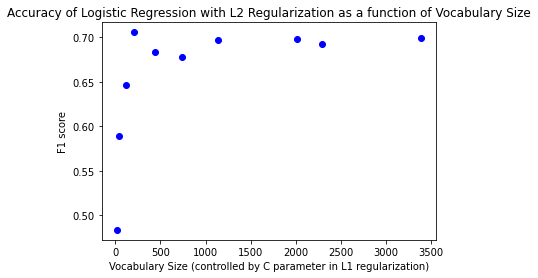

In [ ]:
def P6():
# Keep this random seed here to make comparison easier.
    np.random.seed(0)
### STUDENT START ###    
# Use default CountVectorizer options
    vectorizer = CountVectorizer()
    doc_matrix_train = vectorizer.fit_transform(train_data)
    doc_matrix_dev = vectorizer.transform(dev_data)
    
# Logistic regression using L2 penalty with the default value of C (1.0)
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    model.fit(doc_matrix_train, train_labels)
    print ("The number of nonzero weights with L2 regularization is: {}.".format(np.count_nonzero(model.coef_)))
    print ("Accuracy is {:.2f}.\n".format(model.score(doc_matrix_dev, dev_labels)))

# Logistic regression using L1 penalty with the default value of C (1.0)
    model = LogisticRegression(penalty='l1', C=0.3, solver='liblinear')
    model.fit(doc_matrix_train, train_labels)
    print ("The number of nonzero weights with L1 regularization is: {}.".format(np.count_nonzero(model.coef_)))
    print ("Accuracy is {:.2f}.\n".format(model.score(doc_matrix_dev, dev_labels)))
    
# Retrain using features with nonzero weights
    # [1] gives the index of the features ([0]: index of class), np.unique yields nonrepeating indices
    nonzero_features = np.unique(np.nonzero(model.coef_)[1])
    # Extract vocab with nonzero features
    nonzero_vocab = np.array(vectorizer.get_feature_names())[nonzero_features]
    
# Vectorize with new vocab
    vectorizer = CountVectorizer(vocabulary=nonzero_vocab)
    doc_matrix_train = vectorizer.fit_transform(train_data)
    doc_matrix_dev = vectorizer.transform(dev_data)

# Fit L2 model with the reduced set of features
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    model.fit(doc_matrix_train, train_labels)
    print ("The number of nonzero weights with L2 regularization and reduced vocab is: {}.".format(np.count_nonzero(model.coef_)))
    print ("It is much smaller after features are pruned by the L1 model.")
    print ("Accuracy is {:.2f}.\n".format(model.score(doc_matrix_dev, dev_labels)))
    
# Initialize C's and empty arrays for vocab_size and accuracy
    Cs = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 1, 3, 5, 10]
    vocab_size = []
    f1 = []
    
# Iterate through different C's
    for val in Cs:
    # First vectorize with standard vocab
        vectorizer = CountVectorizer()
        doc_matrix_train = vectorizer.fit_transform(train_data)
    # Fit a L1 model with C value and tol=0.01 to ensure convergence. Lower C value prunes more features.
        model = LogisticRegression(penalty='l1', C=val, tol=0.015, solver='liblinear')
        model.fit(doc_matrix_train, train_labels)
    # Obtain features with nonzero weights
        nonzero_features = np.unique(np.nonzero(model.coef_)[1])
        nonzero_vocab = np.array(vectorizer.get_feature_names())[nonzero_features]
        vocab_size.append(len(nonzero_vocab))
    # Vectorize with new vocab
        vectorizer = CountVectorizer(vocabulary=nonzero_vocab)
        doc_matrix_train = vectorizer.fit_transform(train_data)
        doc_matrix_dev = vectorizer.transform(dev_data)
    # Fit L2 model with default C=1.0
        model = LogisticRegression(penalty='l2', C=1.0, tol=0.015, solver='liblinear')
        model.fit(doc_matrix_train, train_labels)
        _pred = model.predict(doc_matrix_dev)
        #accuracy.append(model.score(doc_matrix_dev, dev_labels))

        f1.append(metrics.f1_score(dev_labels, _pred, average='micro'))
    
# Create plot
    plt.plot(vocab_size, f1, 'bo')
    plt.xlabel("Vocabulary Size (controlled by C parameter in L1 regularization)")
    plt.ylabel("F1 score")
    plt.title("Accuracy of Logistic Regression with L2 Regularization as a function of Vocabulary Size")
    
    ### STUDENT END ###
    
P6()

***Parameters being fed in***
C Values: [0.001, 0.01, 0.1, 0.5, 1.0, 10, 25, 50, 75, 100]
tol value set to: 0.015
solver type set to: liblinear
*****C Value: 0.001*****
Unpruned vocabulary size: 26879
Pruned vocabulary size: 2
F1 score of Logistic L1: 0.24
F1 score of Logistic L2 (with pruned vocabulary): 0.31
*****C Value: 0.01*****
Unpruned vocabulary size: 26879
Pruned vocabulary size: 18
F1 score of Logistic L1: 0.42
F1 score of Logistic L2 (with pruned vocabulary): 0.46
*****C Value: 0.1*****
Unpruned vocabulary size: 26879
Pruned vocabulary size: 221
F1 score of Logistic L1: 0.65
F1 score of Logistic L2 (with pruned vocabulary): 0.68
*****C Value: 0.5*****
Unpruned vocabulary size: 26879
Pruned vocabulary size: 739
F1 score of Logistic L1: 0.69
F1 score of Logistic L2 (with pruned vocabulary): 0.67
*****C Value: 1.0*****
Unpruned vocabulary size: 26879
Pruned vocabulary size: 1169
F1 score of Logistic L1: 0.69
F1 score of Logistic L2 (with pruned vocabulary): 0.68
*****C Value: 1

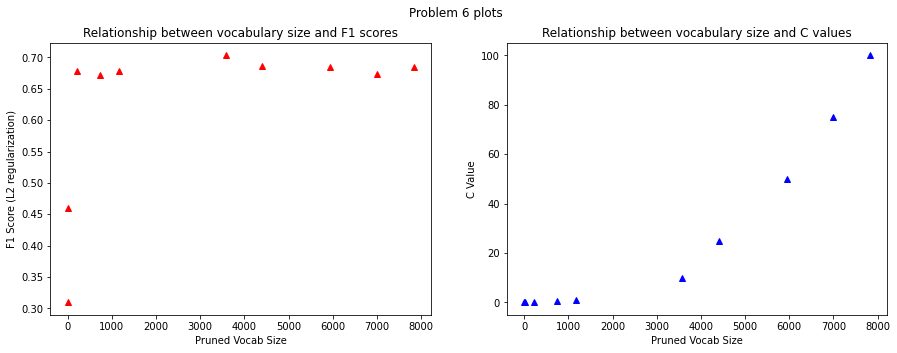

In [ ]:
def P6():
  # Keep this random seed here to make comparison easier.
  np.random.seed(0)

  ### STUDENT START ###

  ##Part 1: Run logistic regression with L1 penalty (tol set to .015 as per notes)
  vectorizer_6 = CountVectorizer()

  feature_vectors_train = vectorizer_6.fit_transform(raw_documents=train_data) #fit transform train data
  feature_vectors_dev = vectorizer_6.transform(raw_documents=dev_data) #fit transform dev data

  print('***Parameters being fed in***')

  C_values = [.001,.01,.1,.5,1.0,10,25,50,75,100]

  print("C Values: " + str(C_values))

  tol_val = .015

  print("tol value set to: " + str(tol_val))

  solver_val = 'liblinear'

  print("solver type set to: " + str(solver_val))

  #create empty lists of pruned vocab sizes, l1 accuracies, l2 accuracies to append to
  pruned_vocab_sizes = []
  l1_f1s = []
  l2_f1s = []

  ######loop through each value of C######
  for C_value in C_values:
    print("*****C Value: " + str(C_value) + "*****")
    logistic_l1 = LogisticRegression(penalty='l1', tol=tol_val, C=C_value,solver = solver_val, multi_class = 'auto')
    logistic_l1.fit(feature_vectors_train, train_labels)
    l1_coef = logistic_l1.coef_

    ##grab non zero features using boolean mask##

    non_zero_features_l1 = []

    for category in l1_coef:
      for i, v in np.ndenumerate(category):
        if v != 0 and i[0] not in non_zero_features_l1:
          #print((i[0], v))
          non_zero_features_l1.append(i[0])
    non_zero_features_l1.sort()    

    boolean_mask = (logistic_l1.coef_ != 0) #create a boolean mask

    flattened_boolean_mask = boolean_mask.any(axis = 0) #flattened boolean mask

    feature_vectors_train_pruned = feature_vectors_train[:,flattened_boolean_mask] #apply boolean mask
    feature_vectors_dev_pruned = feature_vectors_dev[:,flattened_boolean_mask] #apply boolean mask

    ##Unpruned##
    default_vocabulary_size = feature_vectors_dev.shape[1]
    print("Unpruned vocabulary size: " + str(default_vocabulary_size))


    ##Pruned##
    pruned_vocabulary_size = feature_vectors_train_pruned.shape[1]
    print("Pruned vocabulary size: " + str(pruned_vocabulary_size)) 
    pruned_vocab_sizes.append(pruned_vocabulary_size)


    prediction_logistic = logistic_l1.predict(feature_vectors_dev)

    print("F1 score of Logistic L1: {:.2f}".format(metrics.f1_score(dev_labels, prediction_logistic, average='weighted')))

    l1_f1s.append(metrics.f1_score(dev_labels, prediction_logistic, average='weighted'))  #append to array to plot later

    ## next - loop through and only select features that match up with indexes from all_features_w_non_zero_weights_l1

    ##Part 2: Run logistic regression with L2 penalty (tol set to .015 as per notes) 

    logistic_l2 = LogisticRegression(penalty='l2', tol=tol_val, C=C_value, solver= solver_val, multi_class = 'auto')    

    logistic_l2.fit(feature_vectors_train_pruned, train_labels)
    l2_coef = logistic_l2.coef_

    prediction_logistic_l2 = logistic_l2.predict(feature_vectors_dev_pruned)

    print("F1 score of Logistic L2 (with pruned vocabulary): {:.2f}" .format(metrics.f1_score(dev_labels, prediction_logistic_l2, average='weighted')))    
    l2_f1s.append(metrics.f1_score(dev_labels, prediction_logistic_l2, average='weighted')) #append to array to plot later


  print("Pruned vocabulary sizes: " + str(pruned_vocab_sizes))

  #####Making plots#####

  fig = plt.figure(figsize =(15,5)) #plot size

  fig.suptitle("Problem 6 plots") #superimposed plot title

  ##defining subplots
  ax1 = fig.add_subplot(121) 
  ax1.title.set_text('Relationship between vocabulary size and F1 scores')
  ax1.set_xlabel('Pruned Vocab Size')
  ax1.set_ylabel('F1 Score (L2 regularization)')

  ax2 = fig.add_subplot(122)
  ax2.title.set_text('Relationship between vocabulary size and C values')
  ax2.set_xlabel('Pruned Vocab Size')
  ax2.set_ylabel('C Value')

  #setting arrays
  x1 = np.array(pruned_vocab_sizes)
  y1 = np.array(l2_f1s)
  y2 = np.array(C_values)

  #plot
  ax1.plot(x1,y1, 'r^')
  ax2.plot(x1,y2, 'b^')
  ### STUDENT END ###

P6()

ANSWER:

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

F1 score of Logistic w/ C = 100: 0.7597662427853104
**********Labels**********
Index Number = 0 alt.atheism
Index Number = 1 comp.graphics
Index Number = 2 sci.space
Index Number = 3 talk.religion.misc
**********Classification Report**********
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       165
           1       0.80      0.91      0.85       185
           2       0.83      0.83      0.83       199
           3       0.68      0.64      0.66       127

    accuracy                           0.76       676
   macro avg       0.75      0.75      0.75       676
weighted avg       0.76      0.76      0.76       676

**********Confusion Matrix**********


<Figure size 432x288 with 0 Axes>

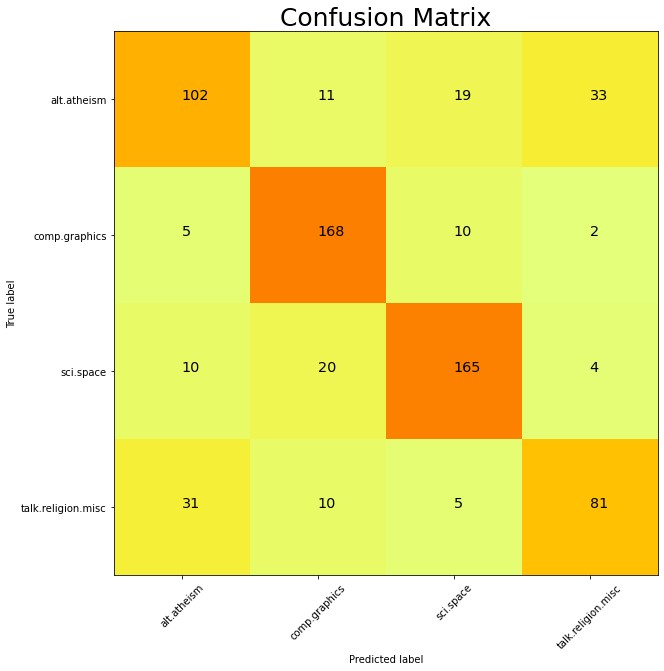

**********5 Features With the Largest Weights for Each Label - Unigram Features**********
     top_words  index  alt.atheism  comp.graphics  sci.space  talk.religion.misc
0      atheism   3866     9.198756      -3.641100  -3.319543           -4.959453
1     atheists   3870     8.164388      -1.224380  -2.409321           -6.295481
2     religion  20430     7.793978      -4.366991  -6.121795           -0.286827
3        bobby   4784     7.348510      -1.825731  -2.759787           -4.105383
4        islam  13668     7.046176      -1.672601  -2.955586           -3.515403
5     graphics  11552    -5.628799      14.064670  -9.439864           -5.614269
6        image  12769    -4.210860      10.115288  -6.152617           -3.481516
7     computer   6555    -0.650493       8.913767  -5.334866           -4.108922
8         file  10376    -2.456896       8.884874  -5.711060           -4.674778
9           3d   1145    -2.846644       8.711330  -5.313877           -2.899798
10       space  225

In [ ]:
import pandas as pd
def P7():
### STUDENT START ###

  ####using TfidfVectorizer####
  vectorizer_tfidf = TfidfVectorizer()
  
  Feature_vectors_train_tfidf = vectorizer_tfidf.fit_transform(raw_documents=train_data)
  Feature_vectors_test_tfidf = vectorizer_tfidf.transform(raw_documents=dev_data)

  logistic = LogisticRegression(penalty='l2', C = 100, solver= 'liblinear', multi_class = 'auto')

  logistic.fit(Feature_vectors_train_tfidf, train_labels)
  
  prediction_logistic = logistic.predict(Feature_vectors_test_tfidf)
  
  print("F1 score of Logistic w/ C = 100: " + str(metrics.f1_score(dev_labels, prediction_logistic, average='weighted')))
  
  ####Max Predicted Probability####
  tfidf_proba = logistic.predict_proba(Feature_vectors_test_tfidf)
  
  max_predicted_probability = []
  
  for i in tfidf_proba:
    max_predicted_probability.append(np.max(i))
    
  ####Predicted Probability of correct label####
  
  correct_label_probabilities = []
  
  for i,v in np.ndenumerate(dev_labels):
    index_num = i[0]
    correct_label_probabilities.append(tfidf_proba[index_num][v]) #specify correct item in array

  #print(correct_label_probabilities)
  

  ####Calculate R for each item in dev_label#### 
  R = []
  
  for i, v in enumerate(max_predicted_probability):
    R.append((v/ correct_label_probabilities[i], i))
  #R = [m / c for m,c in zip(max_predicted_probability, correct_label_probabilities)]
  #print(R)
  
 
  #sort this list of tuples to find some of the max values of R
  
  sorted_by_first = sorted(R, key=lambda tup: tup[0], reverse=True)
  #print(sorted_by_first)   
  
  print('**********Labels**********')
  for i, v in enumerate(newsgroups_train.target_names):
    print('Index Number = ' + str(i) + ' ' + v)

  ###classification report###
  
  
  print('**********Classification Report**********')
  print(classification_report(dev_labels,prediction_logistic))
  
  print('**********Confusion Matrix**********')
  cm = metrics.confusion_matrix(dev_labels, prediction_logistic)
  plt.clf()
  plt.figure(figsize=(10,10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
  plt.title('Confusion Matrix', fontsize = 25)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'], 
       ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
       ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'], 
       ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
      ]

  for i in range(4):
      for j in range(4):
          plt.text(j,i, str(cm[i][j]), size='x-large')
  plt.show()

  
  #####top unigram features
  
  master_list = []
  top_words = []
  index_list = []
  label_0_weights = []
  label_1_weights = []
  label_2_weights = []
  label_3_weights = []
  feature_names = vectorizer_tfidf.get_feature_names()
  
  #top feature list
  for j in logistic.coef_:
    weight_index_list = []
    word_list = []
    #loop through the weights for each label
    for i, v in np.ndenumerate(j):
      index = i[0]
      value = v.tolist()
      weight_index_list.append((index, value)) #append the index and values into a tuple
    sorted_by_weight = sorted(weight_index_list, key=lambda tup: tup[1], reverse=True)[0:5] #sort appended list by feature, return top 5 words for each feature
    for i in sorted_by_weight:
      top_words.append(feature_names[i[0]]) 
      index_list.append(i[0])
      label_0_weights.append(logistic.coef_[0][i[0]])
      label_1_weights.append(logistic.coef_[1][i[0]])
      label_2_weights.append(logistic.coef_[2][i[0]])
      label_3_weights.append(logistic.coef_[3][i[0]])
    #top_words.append(word_list)
    
    master_list.append(sorted_by_weight)

  
  #display options for pandas to show table nicely
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 1000)
  
  #initialize data structure to output to table
  table_data = {'top_words': top_words, 'index': index_list, 'alt.atheism': label_0_weights, 'comp.graphics': label_1_weights , 'sci.space': label_2_weights, 'talk.religion.misc' : label_3_weights}
  table_data_df = pd.DataFrame.from_dict(table_data)
  
  print("**********5 Features With the Largest Weights for Each Label - Unigram Features**********")
  print(table_data_df)
  
  
  
  ###print top 3 items###
  print("**********Examining dev data with highest R values**********")
  for i in range(0,3):
    print("*****R score and dev data index for: " + str(sorted_by_first[i]) + ", R value rank: " + str(i+1) + "*****")
    print("Actual Label: "+ str(dev_labels[sorted_by_first[i][1]]) + " " + str(newsgroups_train.target_names[dev_labels[sorted_by_first[i][1]]]))
    print("Predicted Label: "+ str(prediction_logistic[sorted_by_first[i][1]]) + " " + str(newsgroups_train.target_names[prediction_logistic[sorted_by_first[i][1]]]))
    print("Text of item:")
    print(dev_data[sorted_by_first[i][1]])
    
## STUDENT END ###
P7()

ANSWER:

CountVectorizer just counts the word frequencies, whereas TFIDFVectorizer, the value increases proportionally to the count, but is offset by the frequency of the word in the dictionary. This helps to adjust for the fact that some words might appear more frequently.

The item at 215 contains keywords that relate to both religion as well as computers (ftp, Mormon).

The item at index 665 is relatively short. It contains keywords that relate to both religion as well as computers (ftp, Mormon). This item could be misclassified by a human

The item at index 607 appears to have the highest R score (55308136). The length of this text is also relatively short. This one might easily be misclassified by a human as well.

From our classification report, we can see that alt.atheism and talk.religion.misc have the lowest F1 scores. Based on the confusion matrix, it appears that alt.atheism and talk.religion.misc both appear to have messages that are mixed between groups.

A possible solution might be to remove features/words from our vocabulary that are common in both atheism and talk.religion.misc, as well as other highly misclassifed topic combinations that we can identify from the confusion matrix. We can also try to perform preprocessing and common stop words in order to better improve the overall classification.



ANSWER:

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [ ]:
##Let's look at stop words
##I will include common stop words provided in scikitlearn, as well as custom stop words. 
#I'll be looking at features that are strong predictors for more than 1 class, and purging those from my classifier
##I tried a couple othere examples, like preprocessing, lemmatization, and bigram/trigrams 
#but stop words and preprocessing provided the best jump in performance that I could find

def better_preprocessor(s):
  #applying different text transformations
  s = re.sub('[^A-Za-z0-9]', ' ', s) #remove non alpha numeric characters
  s = re.sub('[/\r?\n|\r/]', ' ', s) #remove line breaks
  #s = re.sub("(\w{7})\w+", "\\1", s) #shortening long words
  #s = re.sub('([0-9]+)', '#', s) #numbers
  return s

def P8():
  ###Initialize vectorizer###
  vectorizer_tfidf_pre = TfidfVectorizer()
  
  #fit vectors
  Feature_vectors_train_tfidf_pre = vectorizer_tfidf_pre.fit_transform(raw_documents=train_data)
  Feature_vectors_dev_tfidf_pre = vectorizer_tfidf_pre.transform(raw_documents=dev_data)
  
  ####fit model on and look for common strong unigram weights####
  
  logistic = LogisticRegression(penalty='l2', C = 100, solver= 'liblinear', multi_class = 'auto')

  logistic.fit(Feature_vectors_train_tfidf_pre, train_labels)
  
  #####top unigram features#####
  
  master_list = []
  top_words_per_class = [] #append top 50 feature words, for 4 classes in 4 lists
  top_words_comprehensive = [] #append top 50 feature words into one big list

  feature_names = vectorizer_tfidf_pre.get_feature_names()
  
  #top feature list
  for j in logistic.coef_:
    weight_index_list = []
    top_word_list = []
    #loop through the weights for each label
    for i, v in np.ndenumerate(j):
      index = i[0]
      value = v.tolist()
      weight_index_list.append((index, value)) #append the index and values into a tuple
    sorted_by_weight = sorted(weight_index_list, key=lambda tup: tup[1], reverse=True)[0:500] #sort appended list by feature, return top 300 words for each feature
    for i in sorted_by_weight:
      top_word_list.append(feature_names[i[0]])  #top 50 features for our keywords to print to table
      top_words_comprehensive.append(feature_names[i[0]])
    top_words_per_class.append(top_word_list)
    master_list.append(sorted_by_weight)

  
  #display options for pandas to show table nicely
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.max_rows', 100)
  pd.set_option('display.width', 1000)
  
  #initialize data structure to output to table
  table_data = {'alt.atheism': top_words_per_class[0][0:50], 'comp.graphics': top_words_per_class[1][0:50] , 'sci.space': top_words_per_class[2][0:50], 'talk.religion.misc' : top_words_per_class[3][0:50]}
  table_data_df = pd.DataFrame.from_dict(table_data)
  #print(top_words_per_class)
  #print(top_words_comprehensive)
  
  print("**********Top 50 Strongest features for each class**********")
  print(table_data_df)
  
  print("**********Common stop Words that show up in our top 500 strongest features for each class**********")  
  matching_stop_words = []
  for i in ENGLISH_STOP_WORDS:
    if i in top_words_comprehensive:
      matching_stop_words.append(i)
  print(matching_stop_words)
    
  
  #####Let's also look at commonly overlapping words in our corpus that are strong predictors for 2 classes#####
  
  #let's look at the 500 top features for alt.atheism, talk.religion.misc, comp graphics, and sci.space

  alt_atheism_list = [] 
  for i in master_list[0]:
    alt_atheism_list.append(i[0])
  
  talk_religion_misc_list = [] 
  for i in master_list[3]:
    talk_religion_misc_list.append(i[0])  
    
  comp_graphics_list = [] 
  for i in master_list[1]:
    comp_graphics_list.append(i[0])
  
  sci_space_list = [] 
  for i in master_list[2]:
    sci_space_list.append(i[0])     
  
  
  #commonly overlapping word combinations. I picked out a few combinations based on the most confused combinations based on the confusion matrix
  print("***Strong feature words that are common in both alt.atheism and talk.religion.misc***")
  overlapping_indicies1 = list(set(alt_atheism_list) & set(talk_religion_misc_list)) #intersection indicies - words that are common in both alt atheism and talk religion misc
  
  overlapping_words1 = []
  for i in overlapping_indicies1:
    overlapping_words1.append(feature_names[i]) 
  print(overlapping_words1)
  
  print("***Strong feature words that are common in both sci.space and comp.graphics***")
  overlapping_indicies2 = list(set(comp_graphics_list) & set(sci_space_list)) 

  overlapping_words2 = []
  for i in overlapping_indicies2:
    overlapping_words2.append(feature_names[i]) 
  print(overlapping_words2)
 

  print("***Strong feature words that are common in both talk.religion.misc and comp.graphics***")
  overlapping_indicies3 = list(set(comp_graphics_list) & set(talk_religion_misc_list)) 

  overlapping_words3 = []
  for i in overlapping_indicies3:
    overlapping_words3.append(feature_names[i]) 
  print(overlapping_words3)
  
  print("***Strong feature words that are common in both alt_atheism and sci.space***")
  overlapping_indicies4 = list(set(alt_atheism_list) & set(sci_space_list)) 

  overlapping_words4 = []
  for i in overlapping_indicies4:
    overlapping_words4.append(feature_names[i]) 
  print(overlapping_words4)  
  
  
  print("***Common Stop Words provided by sklearn that we will filter on***")
  print(ENGLISH_STOP_WORDS)
  
  ####part 2 - Apply stopword transformations and vocab processing####
   
  print("******Model evaluation******")
  
  ##combined stopwords
  
  overlapping_words = overlapping_words1 + overlapping_words2 + overlapping_words3 + overlapping_words4
  updated_stop_words = ENGLISH_STOP_WORDS.union(overlapping_words)
  
  #initialize new vectorizer utilizing our updated stop words
 
  vectorizer_tfidf = TfidfVectorizer(lowercase = True,
                                    stop_words = updated_stop_words
                                    )
  
  ##apply preprocessing
  train_data2 = train_data.copy() #create a copy to apply pruning to

  #apply preprocessing to each item - train
  for i, v in enumerate(train_data2):
    train_data2[i] = better_preprocessor(v)
    
  dev_data2 = dev_data.copy() #create a copy to apply pruning to
 
  #apply preprocessing to each item - dev
  for i, v in enumerate(dev_data2):
    dev_data2[i] = better_preprocessor(v)  
    
    
  test_data2 = test_data.copy() #create a copy to apply pruning to
 
  #apply preprocessing to each item - test
  for i, v in enumerate(test_data2):
    test_data2[i] = better_preprocessor(v)  
  
  
  #create new feature vectors
  Feature_vectors_train_tfidf = vectorizer_tfidf.fit_transform(raw_documents=train_data2)
  Feature_vectors_test_tfidf = vectorizer_tfidf.transform(raw_documents=test_data2)
  Feature_vectors_dev_tfidf = vectorizer_tfidf.transform(raw_documents=dev_data2)
  
  #no transformations on dev  
  logistic1 = LogisticRegression(penalty='l2', C = 100, solver= 'liblinear', multi_class = 'auto')
  logistic1.fit(Feature_vectors_train_tfidf_pre, train_labels)
  prediction_logistic1 = logistic1.predict(Feature_vectors_dev_tfidf_pre)
  print("F1 score of Logistic w/ no purging, evaluated on dev: " + str(metrics.f1_score(dev_labels, prediction_logistic1, average='weighted')))
  
  #refit model on dev  
  logistic2 = LogisticRegression(penalty='l2', C = 100, solver= 'liblinear', multi_class = 'auto')
  logistic2.fit(Feature_vectors_train_tfidf, train_labels)
  prediction_logistic2 = logistic2.predict(Feature_vectors_dev_tfidf)
  print("F1 score of Logistic w/ purged stop words and text tranformations, evaluated on dev: " + str(metrics.f1_score(dev_labels, prediction_logistic2, average='weighted')))
  
  #refit model on test
  logistic3 = LogisticRegression(penalty='l2', C = 100, solver= 'liblinear', multi_class = 'auto')
  logistic3.fit(Feature_vectors_train_tfidf, train_labels)
  prediction_logistic3 = logistic3.predict(Feature_vectors_test_tfidf)
  print("F1 score of Logistic w/ purged stop words and text tranformations, evaluated on test: " + str(metrics.f1_score(test_labels, prediction_logistic3, average='weighted')))
P8()


**********Top 50 Strongest features for each class**********
     alt.atheism comp.graphics   sci.space talk.religion.misc
0        atheism      graphics       space          christian
1       atheists         image       orbit              blood
2       religion      computer        nasa         christians
3          bobby          file      launch                fbi
4          islam            3d  spacecraft              order
5        atheist        points        moon             christ
6          motto            hi        mars             hudson
7        islamic            42     shuttle             koresh
8          nanci           sgi          dc              jesus
9   enviroleague         files        nick           children
10      deletion          code       allen          objective
11       matthew           3do       solar           abortion
12         loans         using         sci          terrorist
13         satan        screen      flight        rosicrucian
14       

ANSWER:

By purging common stop words from our corpus, lowercasing all the text in our vectorizer, as well as stop words that are common in multiple classes, I was able to improve the F1 score from #7 by approximately 1.6% when compared to dev (75.9% -> 77.5%) and 2.2% compared to test (75.9% -> 78.1%), everything else remaining equal (F1 scores may change slightly upon rerunning).

We can also see that there are quite a few common stop words that will be purged when we implement a stopword filter.